In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Stimuli

## Example stimuli delivered

In [2]:
lfp_data = pd.read_pickle('../data/lfp-abby/processed/trial_averages.pkl')
select_stimuli = np.vstack(lfp_data[(lfp_data["fish_id"] == "fish_01") & (lfp_data["zone"] == "mz")]["waveform"]).T
base_stimulus = lfp_data["base_waveform"].iloc[0]
sampling_rate = lfp_data["stimulus_sampling_rate"].iloc[0]

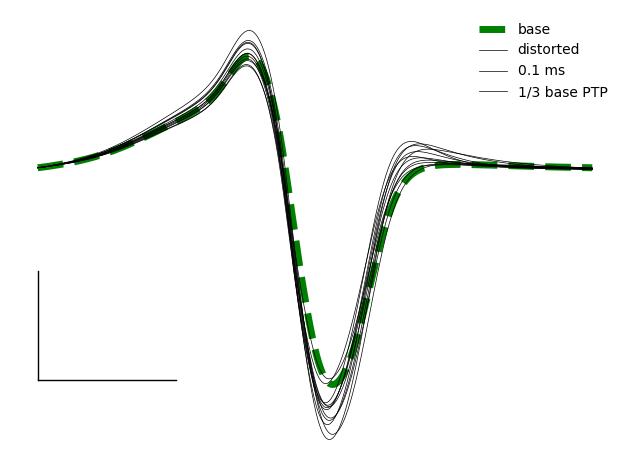

In [3]:
plt.figure()
plt.plot(base_stimulus, "green", ls="--", lw=5)
plt.plot(select_stimuli[:, ::20], "k", lw=0.5)
plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
plt.plot([0, 0], [-1, -1 + base_stimulus.ptp()/3], "k", lw=1)
plt.legend(["base", "distorted", "0.1 ms", "1/3 base PTP"], loc=1, frameon=False)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("example_stimuli.svg")
plt.show()

## Delivered vs. recorded stimuli

In [4]:
stimulus_delivery_data = pd.read_pickle('../data/stimulus-delivery-nate/processed/delivered-vs-recorded.pkl')

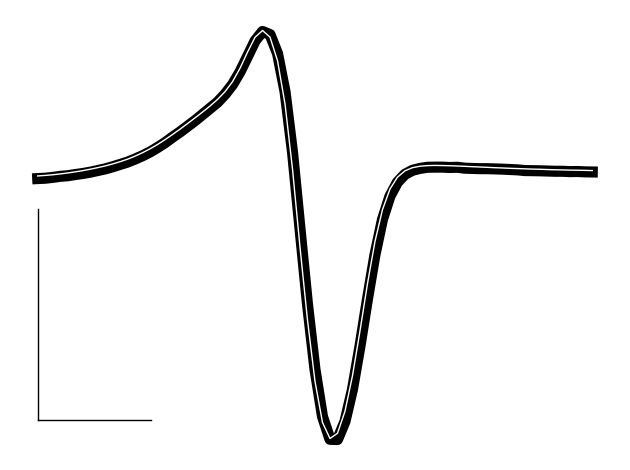

In [5]:
id = 0

dfrow = stimulus_delivery_data.iloc[id]

plt.figure()
# plt.plot(dfrow["stimulus_time"]*1e3, dfrow["stimulus"], label="stimulus", color='k', lw=8)
plt.plot(dfrow["recording_digital_time"]*1e3, dfrow["recording_digital"], label="stimulus", color='k', lw=8)
plt.plot(dfrow["recording_real_time"]*1e3, dfrow["recording_real"], label="stimulus", color='w', lw=1)
# plt.plot(dfrow["stimulus_time"]*1e3, dfrow["recording_real_interpolated"], label="interpolated", color='w', lw=1)

plt.plot([0, 0.1], [-0.6, -0.6], "k", lw=1)
plt.plot([0, 0], [-0.6, -0.6 + base_stimulus.ptp()/3], "k", lw=1)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("delivered_vs_recorded_example.svg")
plt.show()

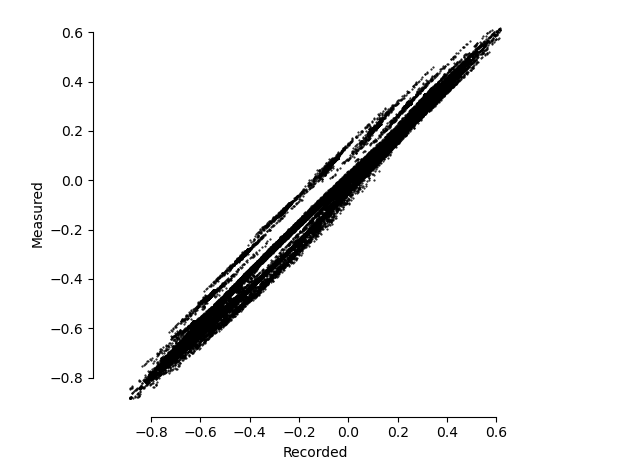

In [6]:
xs = np.hstack(stimulus_delivery_data["recording_digital"])
ys = np.hstack(stimulus_delivery_data["recording_real"])

fig = plt.figure()
plt.scatter(xs, ys, marker=".", color="k", s=1)
plt.axis("equal")
plt.xlabel("Recorded")
plt.ylabel("Measured")
sns.despine(offset={"left": -60}, trim=True)
plt.tight_layout()
plt.savefig("delivered_vs_recorded_scatter.svg")
# fig.set_size_inches(20, 20)
plt.savefig("delivered_vs_recorded_scatter.png", dpi=1000)
plt.show()

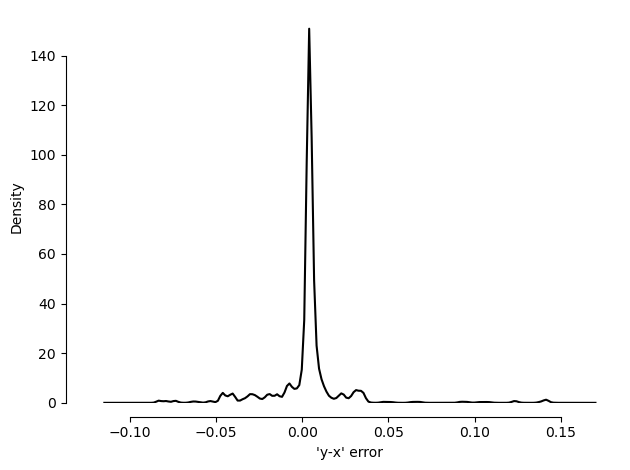

In [7]:
plt.figure()
sns.kdeplot(ys-xs, color='k')
sns.despine(offset=10, trim=True)
plt.xlabel("'y-x' error")
plt.tight_layout()
plt.savefig("delivered_vs_recorded_error-kdeplot.svg")
plt.show()

## LFP for MZ and DLZ

In [8]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
lfp_data = lfp_data[lfp_data["fish_id"] == "fish_09"]
lfp_sampling_rate = lfp_data["lfp_sampling_rate"].iloc[0]
cmap = plt.cm.viridis  # type: ignore

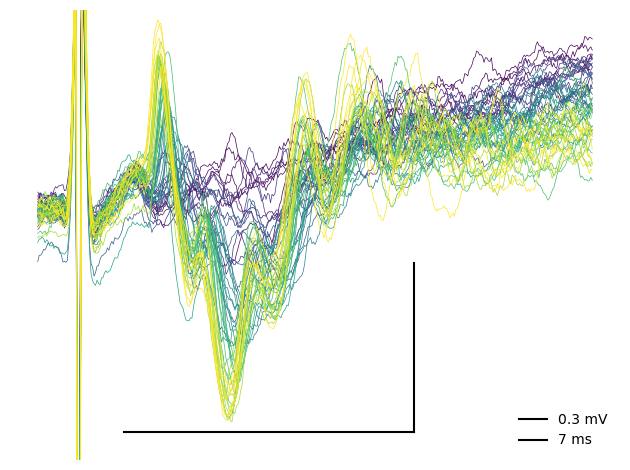

DLZ modulations: -0.142 to 0.000


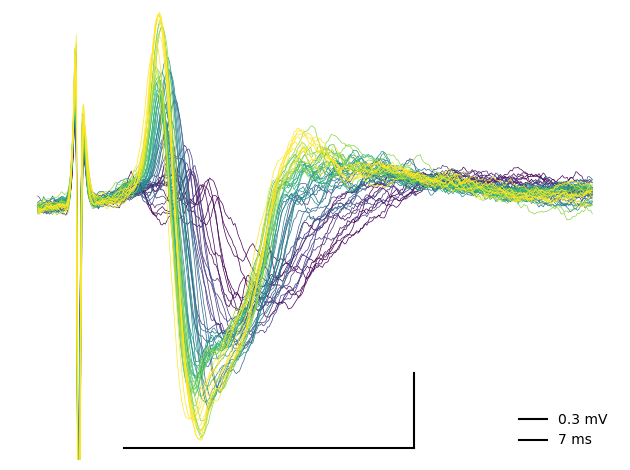

MZ modulations: -0.100 to 0.201


""


In [9]:
def plot_lfp_traces(dfgroup, cmap=cmap, lfp_sampling_rate=lfp_sampling_rate):
    plt.figure()
    zone = dfgroup["zone"].iloc[0]
    lfp_traces = np.vstack(
        dfgroup["lfp_trace"].apply(lambda x: x[0][7])
    )  # arbitrarily choose the 0th bout and 7th trial
    if zone == "dlz":
        modulations = np.hstack(dfgroup["stimulus_waveform_modulation_x"])
        plt.ylim(-0.4, 0.4)
        plt.plot(
            [30 + 8e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate],
            [-0.35, -0.05],
            "k",
            label="0.3 mV",
        )
        plt.plot([30 + 1e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate], [-0.35, -0.35], "k", label="7 ms")
    elif zone == "mz":
        modulations = np.hstack(dfgroup["stimulus_amplitude_modulation_x"])
        plt.plot(
            [30 + 8e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate],
            [-0.9, -0.6],
            "k",
            label="0.3 mV",
        )
        plt.plot([30 + 1e-3 * lfp_sampling_rate, 30 + 8e-3 * lfp_sampling_rate], [-0.9, -0.9], "k", label="7 ms")
        plt.ylim(-0.95, 0.85)
    sort_order = np.argsort(modulations)
    lfp_traces = lfp_traces[sort_order]
    modulations = modulations[sort_order]
    color_norm = mpl.colors.Normalize(vmin=modulations.min(), vmax=modulations.max())  # type: ignore
    for i in range(0, lfp_traces.shape[0], 1):
        plt.plot(lfp_traces[i][225:600], color=cmap(color_norm(modulations[i])), lw=0.5)
    plt.legend(loc=4, frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    plt.savefig(f"lfp_traces_{zone}.svg")
    plt.show()
    print(f"{zone.upper()} modulations: {modulations.min():.3f} to {modulations.max():.3f}")


lfp_data.groupby("zone").apply(plot_lfp_traces)

## Alignment with PP and P/N

In [10]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
cmap = plt.cm.plasma  # type: ignore

In [11]:
def plot_alignment_heatmap(dfgroup, cmap=cmap, inverse_arrow_length=10, arrow_width=0.005):
    fish_id = dfgroup["fish_id"].iloc[0]
    session_id = dfgroup["session_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    xs = np.hstack(dfgroup["stimulus_amplitude_modulation_x"])
    ys = np.hstack(dfgroup["stimulus_waveform_modulation_x"])
    responses = dfgroup["mean_lfp_response_modulation"] * 100
    reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)
    grad_vec = reg.coef_ / np.linalg.norm(reg.coef_)

    color_norm = mpl.colors.Normalize(vmin=responses.min(), vmax=responses.max())  # type: ignore
    fig = plt.figure()
    plt.scatter(xs, ys, c=cmap(color_norm(responses)), s=100, marker="o")
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=color_norm, cmap=cmap),
        ax=plt.gca(),
        shrink=0.5,
        label="Mean LFP Response Modulation (%)",
    )
    sns.despine(ax=cbar.ax, left=False, bottom=False)
    x0, y0 = 0, 0
    if zone == "mz":
        x0 = plt.gca().get_xlim()[0]
        y0 = np.mean(plt.gca().get_ylim())
        inverse_arrow_length /= 2
    elif zone == "dlz":
        x0 = np.mean(plt.gca().get_xlim())
        y0 = plt.gca().get_ylim()[0]
    plt.arrow(
        x0,  # type: ignore
        y0,  # type: ignore
        grad_vec[0] / inverse_arrow_length,
        grad_vec[1] / inverse_arrow_length,
        facecolor="y",
        width=arrow_width,
        edgecolor="k",
        lw=1,
    )
    sns.despine(offset={"bottom": -35, "left": 10}, trim=True)
    plt.axis("equal")
    plt.tight_layout()
    plt.savefig(f"response_heatmap-{zone}-{fish_id}-{session_id}.svg")
    plt.show()
    return pd.Series(
        dict(
            grad_angle=np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi),
            grad_vec=grad_vec,
            reg_r2=reg.score(np.stack([xs, ys]).T, responses),
        )
    )

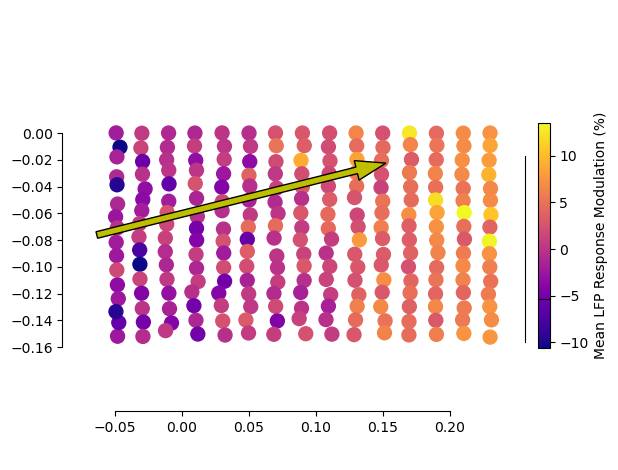

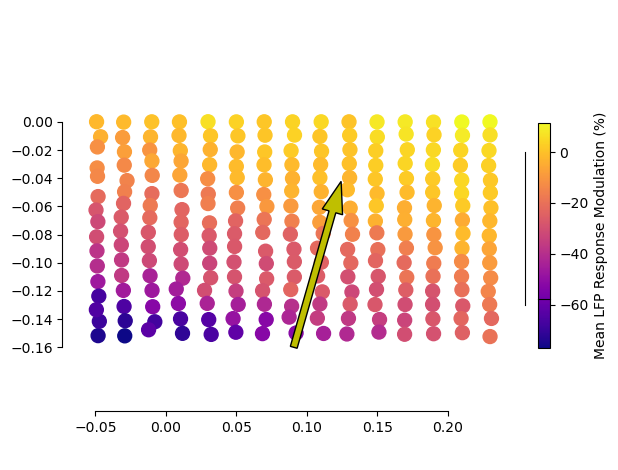

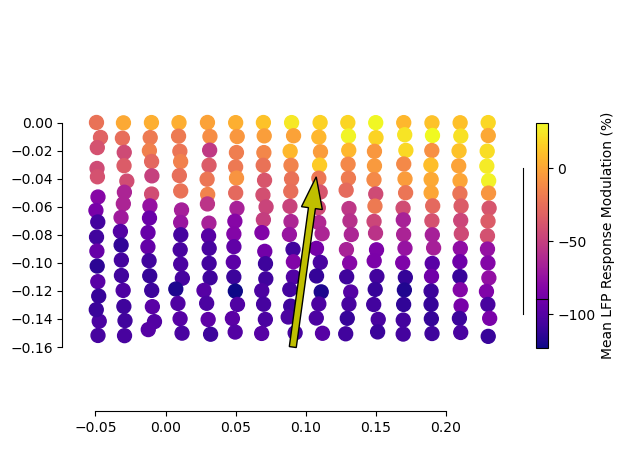

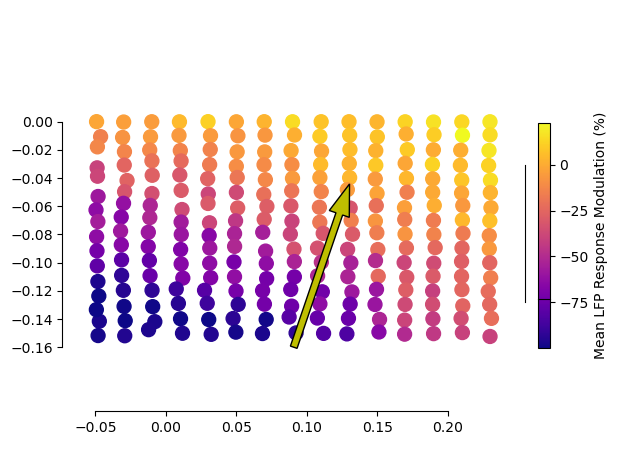

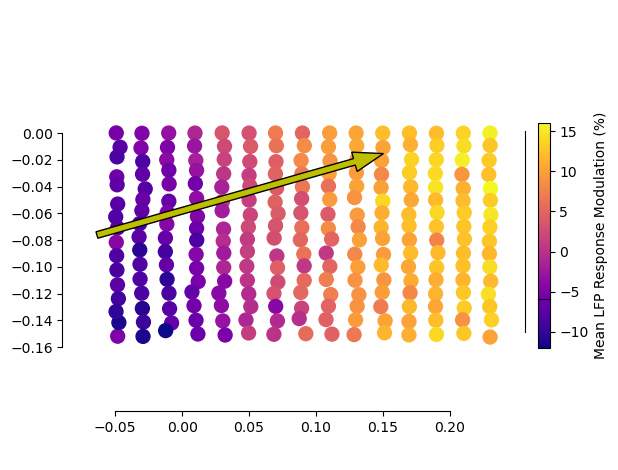

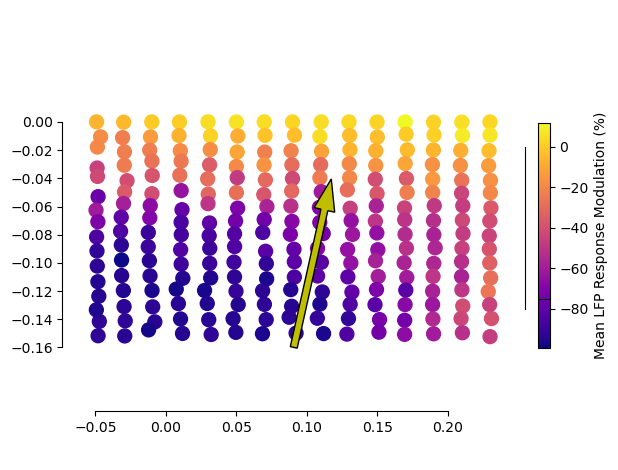

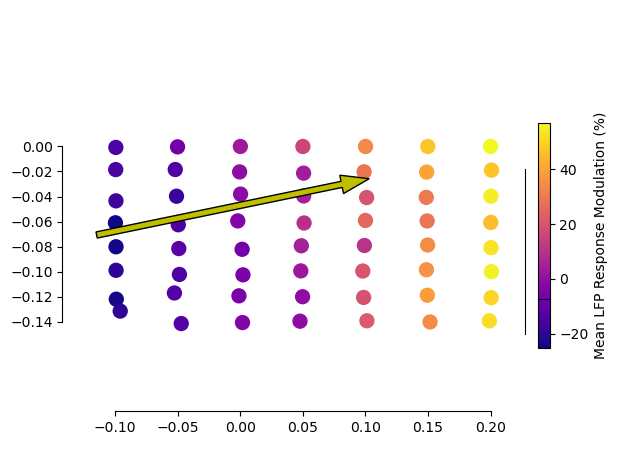

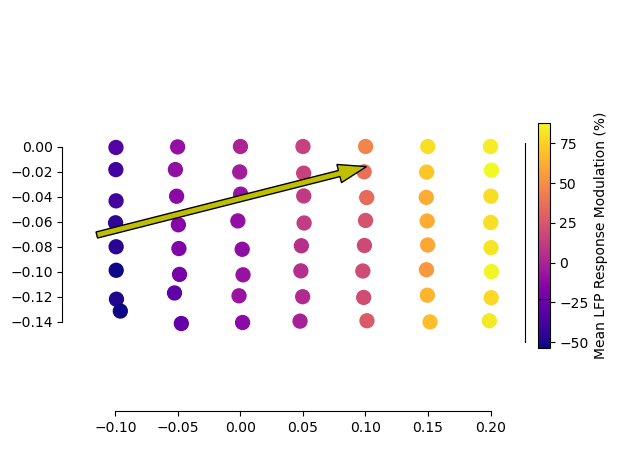

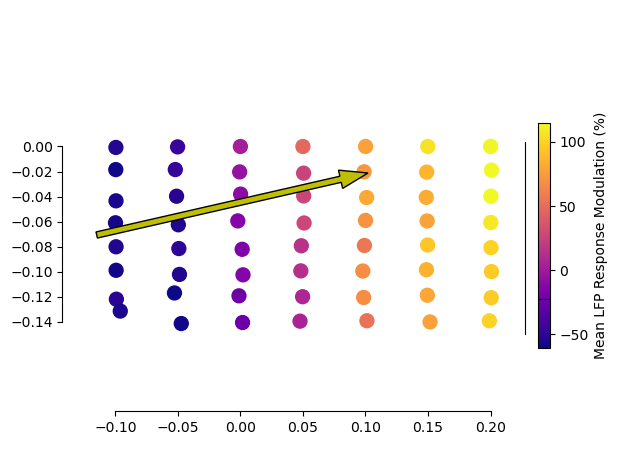

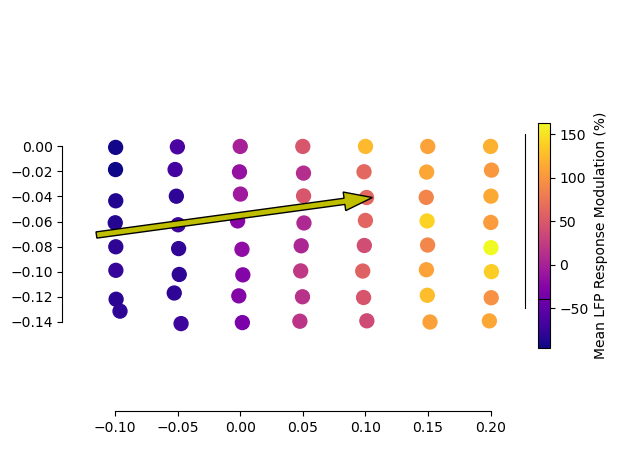

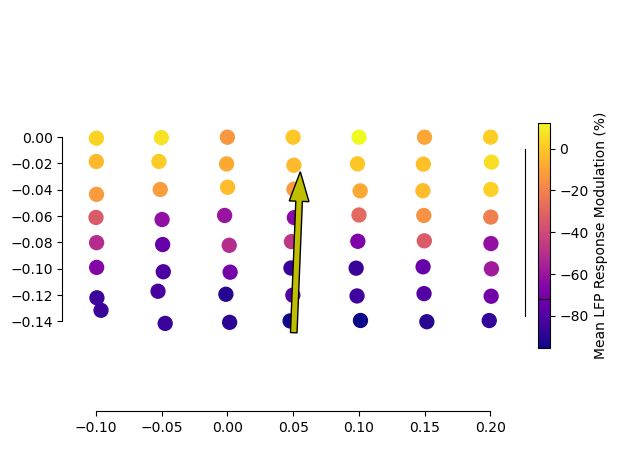

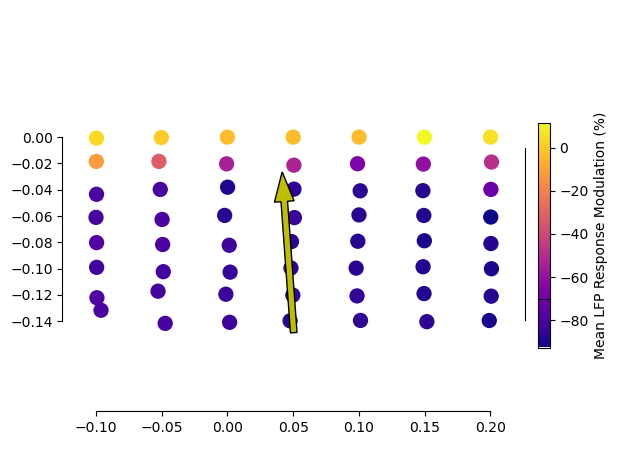

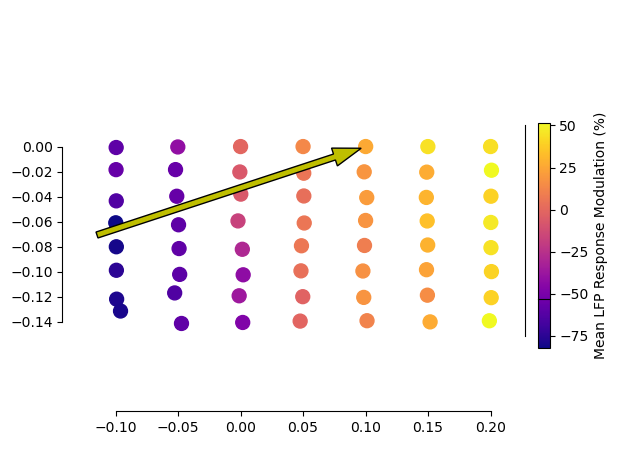

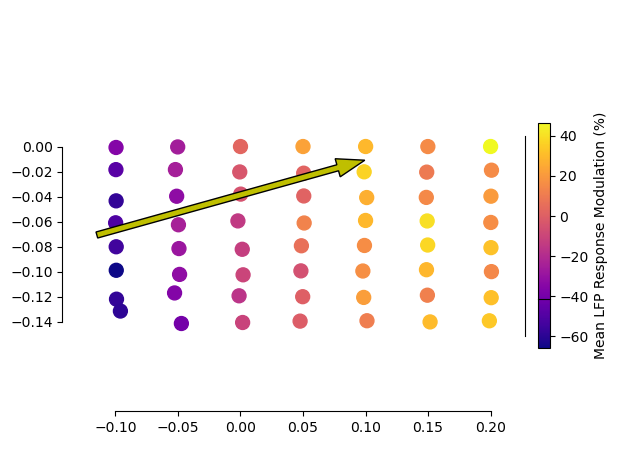

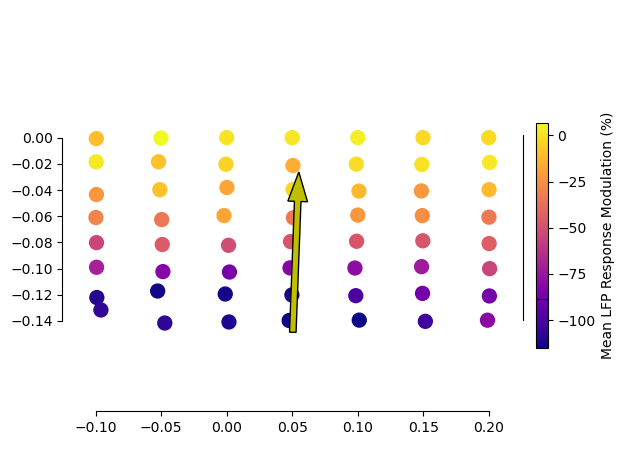

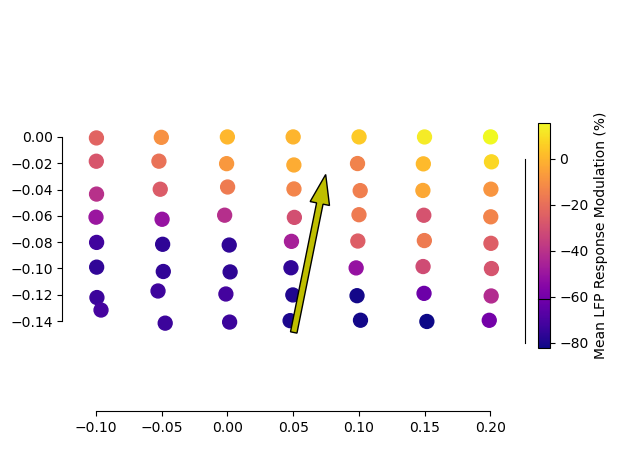

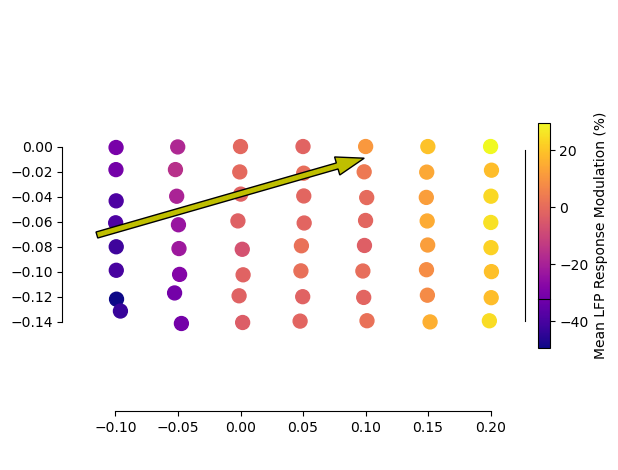

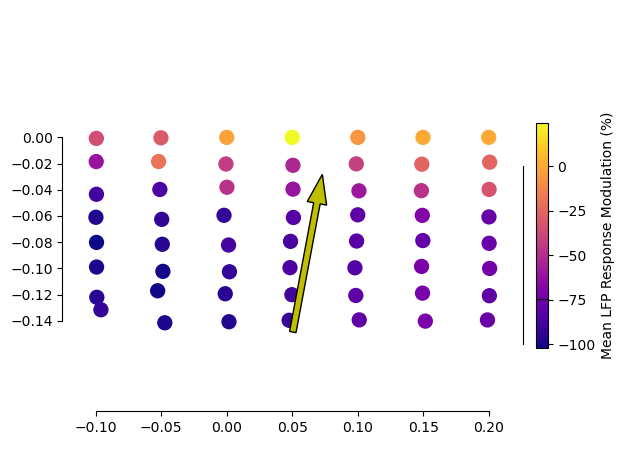

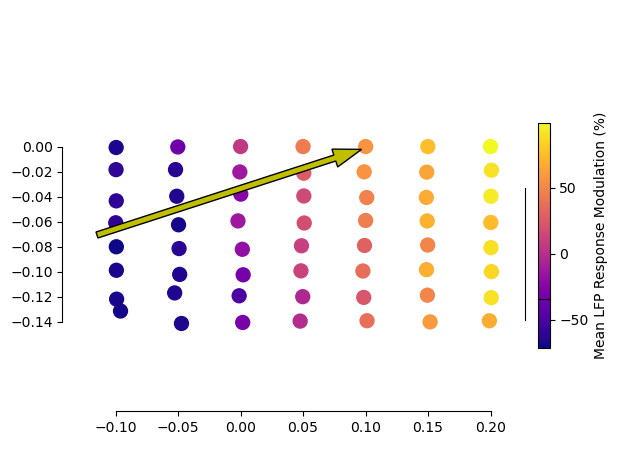

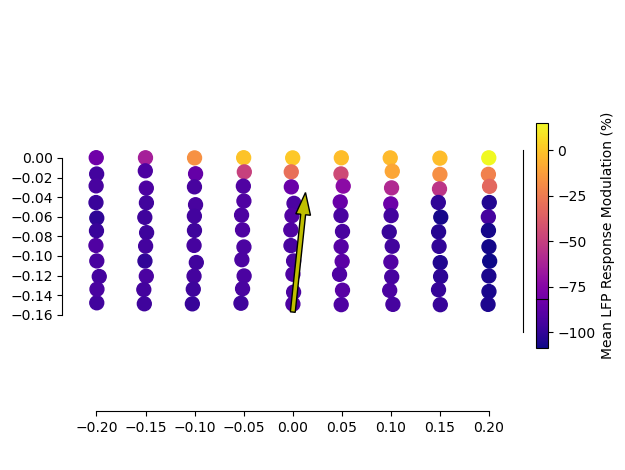

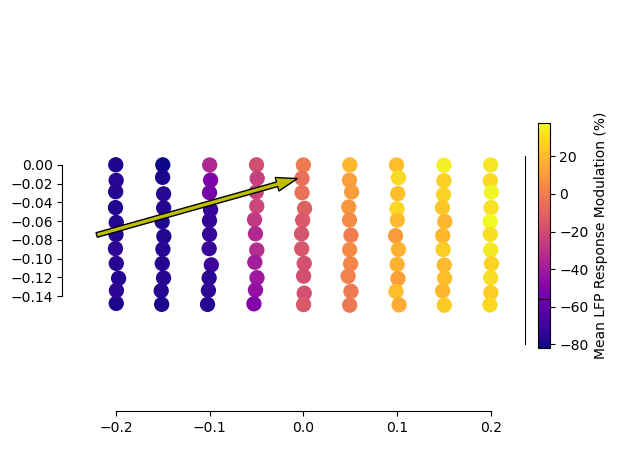

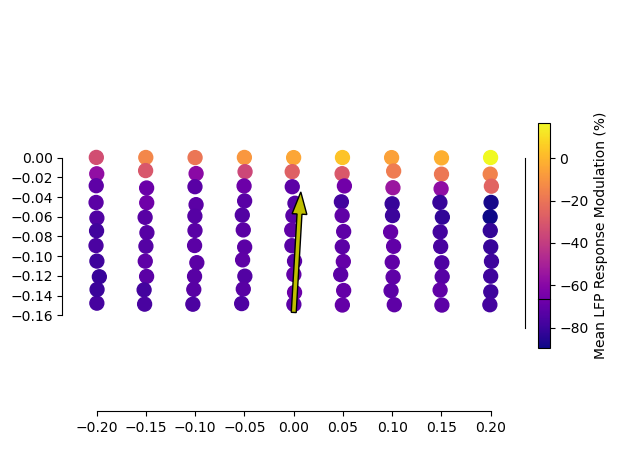

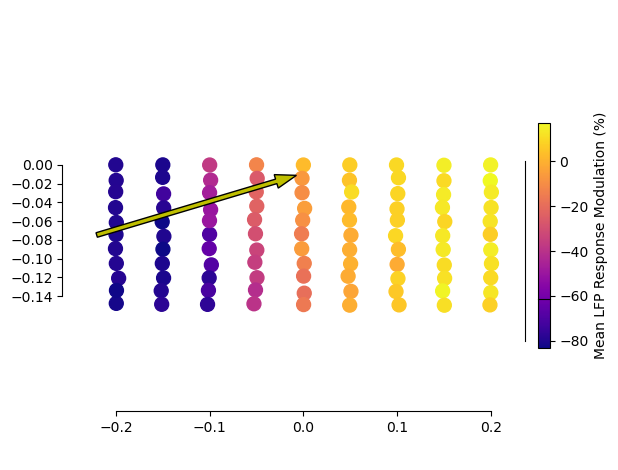

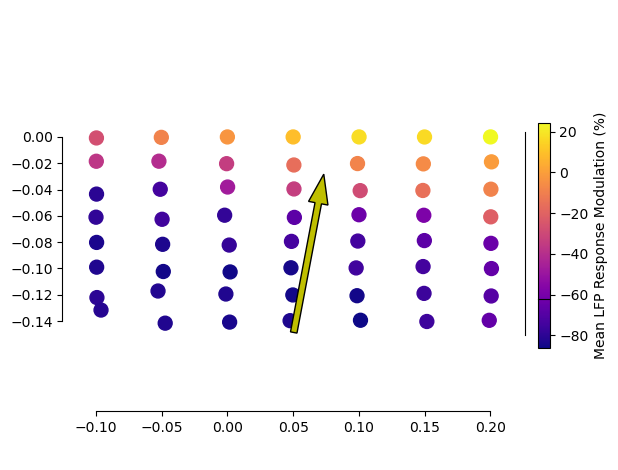

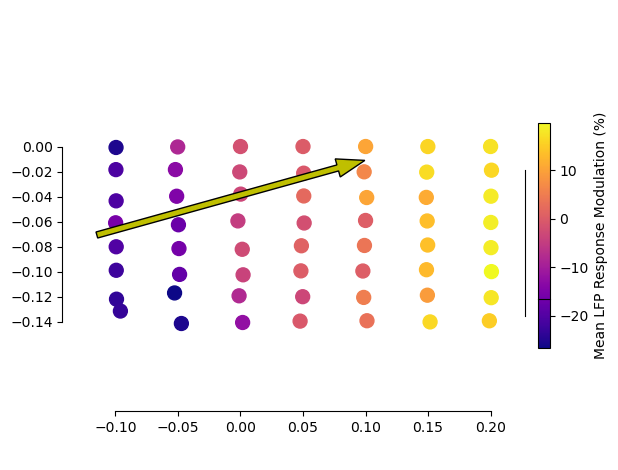

In [12]:
alignment_summary_pppn = lfp_data.groupby(["fish_id", "session_id", "zone"]).apply(plot_alignment_heatmap).reset_index()

In [13]:
alignment_summary_pppn

,fish_id,session_id,zone,grad_angle,grad_vec,reg_r2
0,fish_01,007,mz,13.965872,"[0.9704396529642838, 0.24134390391008526]",0.662481
1,fish_01,009,dlz,74.067561,"[0.2745036848883162, 0.961586047622747]",0.917858
2,fish_02,002,dlz,82.166107,"[0.13630161563291943, 0.9906673859453816]",0.875612
3,fish_03,001,dlz,71.135014,"[0.3233392012775365, 0.9462831293630911]",0.927920
4,fish_03,004,mz,15.863770,"[0.9619143498563086, 0.27335102622912333]",0.929544
5,fish_04,003,dlz,77.435982,"[0.21753031665992556, 0.9760535647872163]",0.834961
6,fish_05,010,mz,11.673071,"[0.9793180107240884, 0.20232704681137947]",0.955894
7,fish_06,003,mz,14.225906,"[0.9693343354373741, 0.24574569404606939]",0.967929
8,fish_06,004,mz,12.869599,"[0.9748795134619276, 0.22273287640632447]",0.965350
9,fish_06,005,mz,7.729770,"[0.9909134488974509, 0.13450106614506502]",0.941205


In [14]:
alignment_summary_pppn.groupby("zone").apply(lambda x: pd.Series(dict(angle_mean=x["grad_angle"].mean(), angle_std=x["grad_angle"].std(), reg_r2_avg=x["reg_r2"].mean())))

,angle_mean,angle_std,reg_r2_avg
zone,,,
dlz,81.854061,6.511642,0.768295
mz,14.765897,2.795192,0.912792


## Show PCA from data stimuli

In [45]:
lfp_data = pd.read_pickle('../data/lfp-abby/processed/trial_averages.pkl')
select_stimuli = np.vstack(lfp_data[(lfp_data["fish_id"] == "fish_01") & (lfp_data["zone"] == "mz")]["waveform"]).T
base_stimulus = lfp_data["base_waveform"].iloc[0]
sampling_rate = lfp_data["stimulus_sampling_rate"].iloc[0]

In [46]:
stimuli_pca = PCA().fit(select_stimuli.T)
explained_variance = stimuli_pca.explained_variance_ratio_
components = stimuli_pca.components_[:2]
components[0] = -components[0]
components = components / components.max(1, keepdims=True)

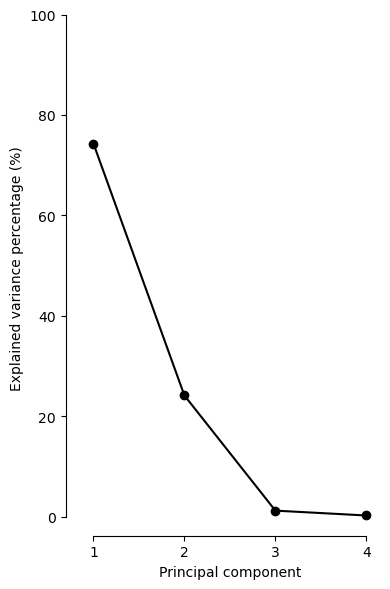

In [47]:
num_comp_to_plot = 4
plt.figure(figsize=(4, 6))
plt.plot(np.arange(num_comp_to_plot).astype(int)+1, explained_variance[:num_comp_to_plot]*100, "k", marker="o")
plt.xlabel("Principal component")
plt.ylabel("Explained variance percentage (%)")
plt.xticks(np.arange(num_comp_to_plot).astype(int)+1)
plt.ylim(-1,100.05)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("stimuli_pca_explained_variance.svg")
plt.show()

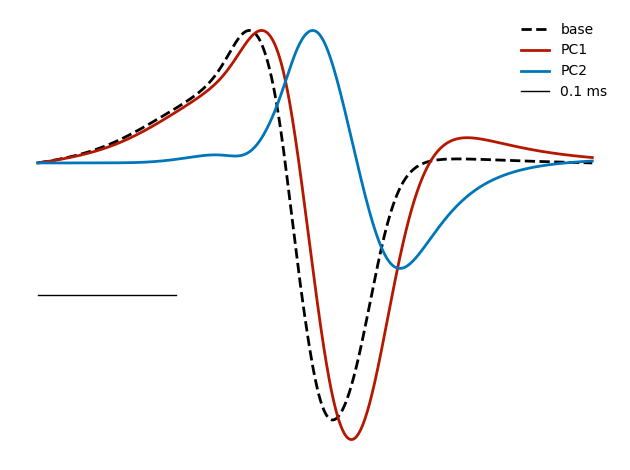

In [54]:
colors = ["#B51700", "#0076BA"]

plt.figure()
plt.plot(base_stimulus / base_stimulus.max(), color="k", ls="--", lw=2)
plt.plot(components[0], color=colors[0], lw=2)
plt.plot(components[1], color=colors[1], lw=2)
plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
plt.legend(["base", "PC1", "PC2", "0.1 ms"], loc=1, frameon=False)
# plt.plot([0, 0], [-1, -1 + base_stimulus.ptp()/3], "k", lw=1)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.tight_layout()
plt.savefig("stimuli_pca_components.svg")
plt.show()

# Receptor Model

In [134]:
filters_models = pd.read_pickle("../filters-models/filters-models.pkl")

train_errors = filters_models[["input_noise_std", "train_error", "zone"]].copy()
train_errors["error"] = train_errors["train_error"]
train_errors.drop(columns="train_error", inplace=True)
train_errors["set"] = "train"

valid_errors = filters_models[["input_noise_std", "valid_error", "zone"]].copy()
valid_errors["error"] = valid_errors["valid_error"]
valid_errors.drop(columns="valid_error", inplace=True)
valid_errors["set"] = "valid"

filters_models_errors = pd.concat(
    [train_errors, valid_errors],
    axis=0,
    ignore_index=True,
)

## Schematic

Draw the schematic separately in drawing apps.

## Validation error as function of input noise STD

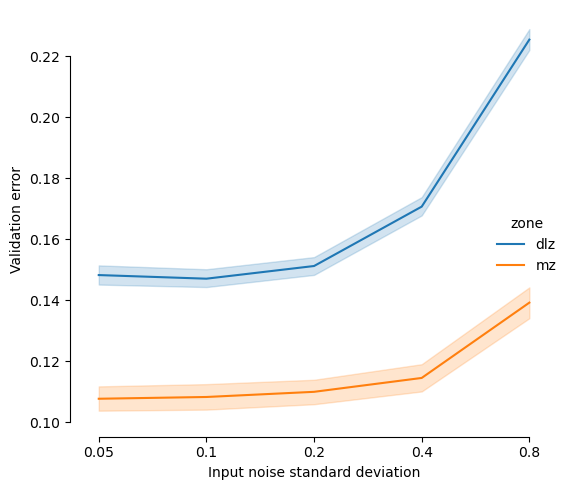

In [135]:
sns.relplot(data=valid_errors, x="input_noise_std", y="error", hue="zone", kind="line")
plt.xlabel("Input noise standard deviation")
plt.ylabel("Validation error")
plt.xscale("log")
plt.minorticks_off()
plt.xticks(valid_errors["input_noise_std"].unique(), valid_errors["input_noise_std"].unique())
sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.savefig("filters_valid_error_with_input_noise.svg")
plt.show()

## True vs predicted LFP

In [ ]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/single_trials.pkl")
conv_filters = filters_models[filters_models["input_noise_std"] == 0.4]

In [218]:
def compute_single_model_prediction(model_row, waveforms):
    conv_filter = model_row["model_filter"]
    conv_bias = model_row["model_bias"]
    bn_mean = model_row["bn_mean"]
    bn_var = model_row["bn_var"]
    bn_weight = model_row["bn_weight"]
    bn_bias = model_row["bn_bias"]

    responses = (conv_bias + np.dot(waveforms, conv_filter) - bn_mean) / np.sqrt(bn_var + 1e-10) * bn_weight + bn_bias

    return responses


def compute_prediction(dfgroup, conv_filters=conv_filters):
    fish_id = dfgroup["fish_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    waveforms = np.vstack(dfgroup["waveform"])
    base_waveform = dfgroup["base_waveform"].iloc[0]
    best_model_idx = conv_filters[(conv_filters["zone"] == zone) & (conv_filters["fish_id"] == fish_id)][
        "valid_error"
    ].idxmin()
    modulations = compute_single_model_prediction(conv_filters.loc[best_model_idx], waveforms)
    return modulations

In [219]:
true_values = lfp_data.groupby(["fish_id", "zone"]).apply(lambda x: x["lfp_response_modulation"].to_numpy()).rename("true").reset_index()
predicted_values = (
    lfp_data.groupby(["fish_id", "zone"]).apply(compute_prediction).rename("predicted").reset_index()
)
true_vs_predicted = pd.merge(true_values, predicted_values, on=["fish_id", "zone"])

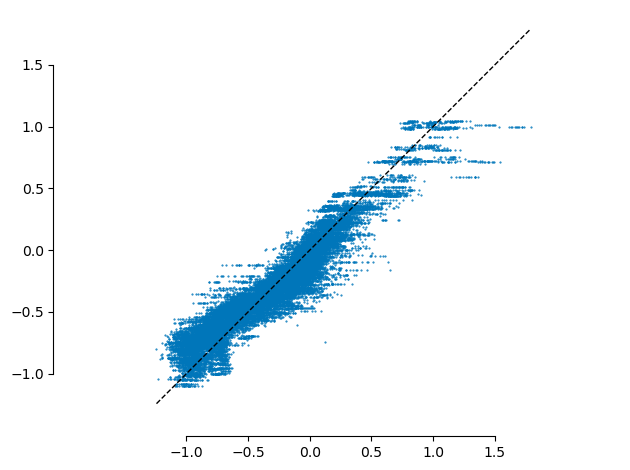

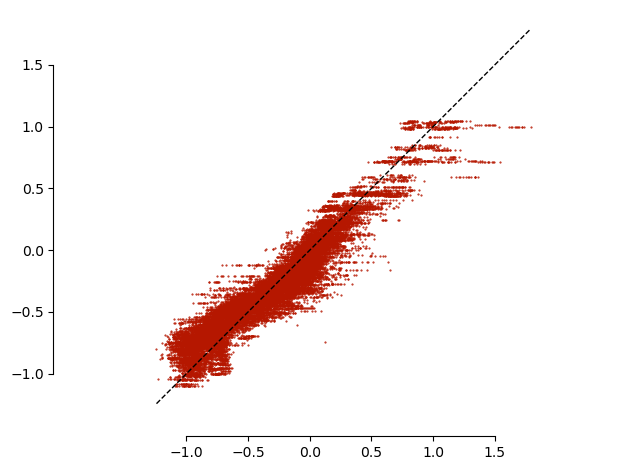

""


In [220]:
def plot_true_vs_predicted(dfgroup, colors=dict(mz="#B51700", dlz="#0076BA")):
    zone = dfgroup["zone"].iloc[0]
    xs = np.hstack(true_vs_predicted["true"])
    ys = np.hstack(true_vs_predicted["predicted"])
    plt.figure()
    plt.scatter(xs, ys, c=colors[zone], s=1, marker=".")
    plt.plot([xs.min(), xs.max()], [xs.min(), xs.max()], "k--", lw=1)
    plt.axis("equal")
    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.show()
    pass


true_vs_predicted.groupby("zone").apply(plot_true_vs_predicted)

## Conv filters

In [221]:
smooth_filters = pd.read_pickle("../data/filters/smooth-filters-all.pkl")
input_noise_std=0.4
sampling_rate = sampling_rate  # defined above

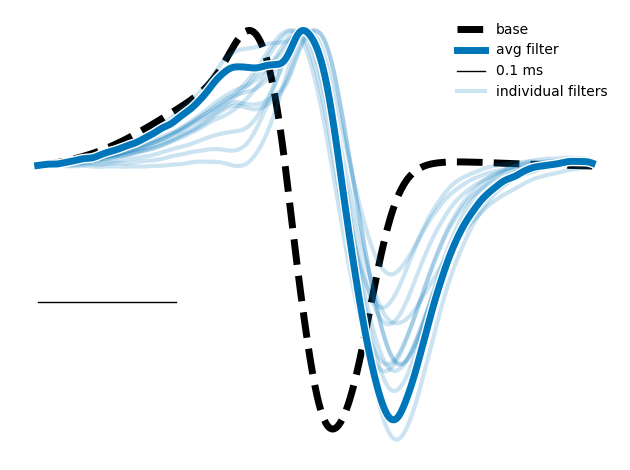

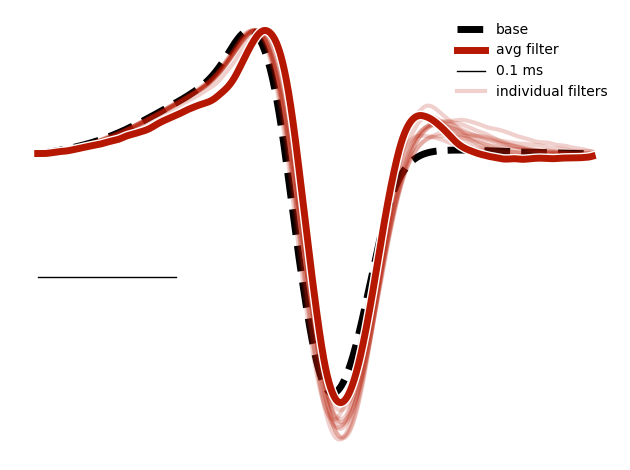

""


In [222]:
def plot_conv_filters(
    dfgroup,
    colors=dict(mz="#B51700", dlz="#0076BA"),
    sampling_rate=sampling_rate,
    base_stimulus=base_stimulus / base_stimulus.max(),
):
    zone = dfgroup["zone"].iloc[0]
    input_noise_std = f"{dfgroup['input_noise_std'].iloc[0]:.2f}".replace(".", "p")
    avg_filter = dfgroup[dfgroup["fish_id"] == "fish"]["model_filter"].iloc[0]
    individual_filters = np.vstack(dfgroup[dfgroup["fish_id"] != "fish"]["model_filter"])

    plt.figure()
    plt.plot(base_stimulus, "k", ls="--", lw=5, zorder=0)
    plt.plot(avg_filter, color=colors[zone], lw=5)
    plt.plot([0, 0.1e-3 * sampling_rate], [-1, -1], "k", lw=1)
    plt.plot(individual_filters.T, color=colors[zone], lw=3, alpha=0.2, zorder=0)
    plt.plot(avg_filter, color="w", lw=7, zorder=1)
    plt.legend(["base", "avg filter", "0.1 ms", "individual filters"], loc=1, frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    plt.savefig(f"filters_waveform_{zone}_{input_noise_std}.svg")
    if input_noise_std == "0p40":
        plt.show()
    plt.close()
    pass


smooth_filters.groupby(["zone", "input_noise_std"]).apply(plot_conv_filters)

## Adaptation panel

## Alignment with conv. features

In [223]:
lfp_data = pd.read_pickle("../data/lfp-abby/processed/trial_averages.pkl")
cmap = plt.cm.plasma  # type: ignore
conv_filters = filters_models[filters_models["input_noise_std"] == 0.4]

In [234]:
def plot_alignment_heatmap_conv_feats(
    dfgroup, cmap=cmap, inverse_arrow_length=10, arrow_width=0.005, conv_filters=conv_filters
):
    fish_id = dfgroup["fish_id"].iloc[0]
    zone = dfgroup["zone"].iloc[0]
    waveforms = np.vstack(dfgroup["waveform"])
    if (
        "mz" in conv_filters[conv_filters["fish_id"] == fish_id]["zone"].unique()
        and "dlz" in conv_filters[conv_filters["fish_id"] == fish_id]["zone"].unique()
    ):
        best_model_mz_idx = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "mz")][
            "valid_error"
        ].idxmin()
        best_model_dlz_idx = conv_filters[(conv_filters["fish_id"] == fish_id) & (conv_filters["zone"] == "dlz")][
            "valid_error"
        ].idxmin()
        xs = compute_single_model_prediction(conv_filters.loc[best_model_mz_idx], waveforms)
        ys = compute_single_model_prediction(conv_filters.loc[best_model_dlz_idx], waveforms)

        responses = dfgroup["mean_lfp_response_modulation"] * 100
        reg = LinearRegression().fit(np.stack([xs, ys]).T, responses)
        grad_vec = reg.coef_ / np.linalg.norm(reg.coef_)

        color_norm = mpl.colors.Normalize(vmin=responses.min(), vmax=responses.max())  # type: ignore
        fig = plt.figure()
        plt.scatter(xs, ys, c=cmap(color_norm(responses)), s=100, marker="o")
        cbar = fig.colorbar(
            plt.cm.ScalarMappable(norm=color_norm, cmap=cmap),
            ax=plt.gca(),
            shrink=0.5,
            label="Mean LFP Response Modulation (%)",
        )
        sns.despine(ax=cbar.ax, left=False, bottom=False)
        x0, y0 = 0, 0
        if zone == "mz":
            x0 = plt.gca().get_xlim()[0]
            y0 = np.mean(plt.gca().get_ylim())
            inverse_arrow_length /= 2
        elif zone == "dlz":
            x0 = np.mean(plt.gca().get_xlim())
            y0 = plt.gca().get_ylim()[0]
        plt.arrow(
            x0,  # type: ignore
            y0,  # type: ignore
            grad_vec[0] / inverse_arrow_length,
            grad_vec[1] / inverse_arrow_length,
            facecolor="y",
            width=arrow_width,
            edgecolor="k",
            lw=1,
        )
        sns.despine(offset=10, trim=True)
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig(f"response_heatmap_conv_feats-{zone}-{fish_id}.svg")
        plt.show()
        return pd.Series(
            dict(
                grad_angle=np.arctan2(grad_vec[1], grad_vec[0]) * 360 / (2 * np.pi),
                grad_vec=grad_vec,
                reg_r2=reg.score(np.stack([xs, ys]).T, responses),
            )
        )

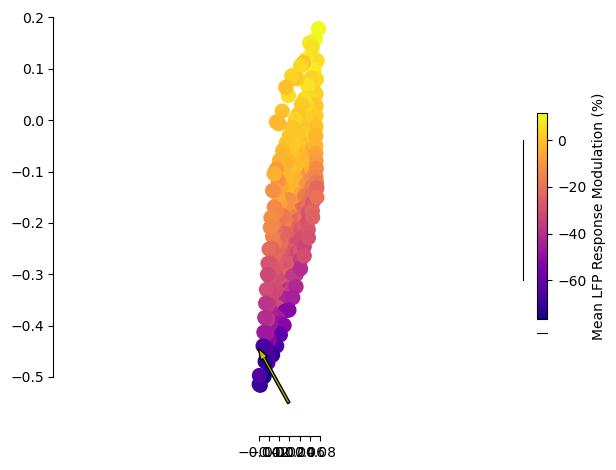

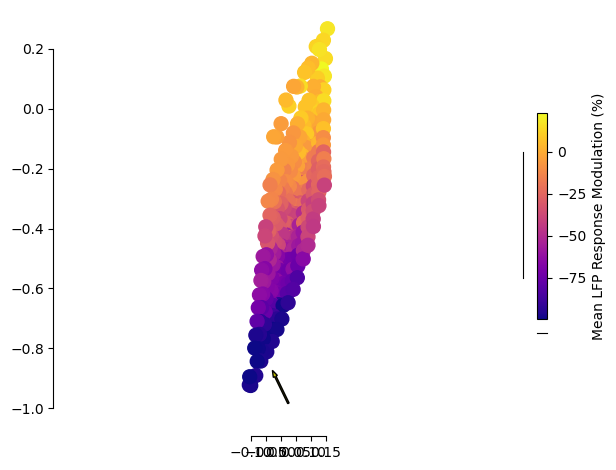

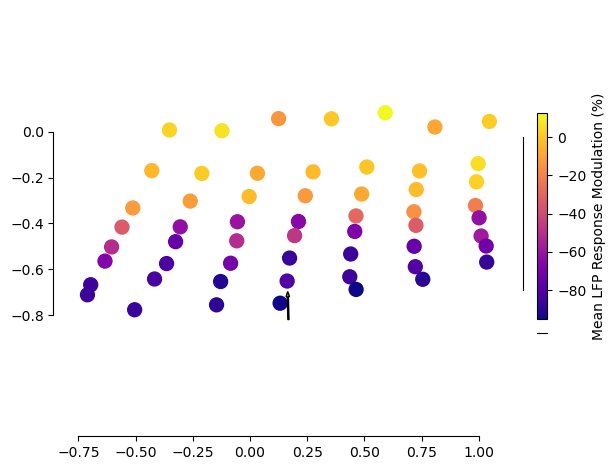

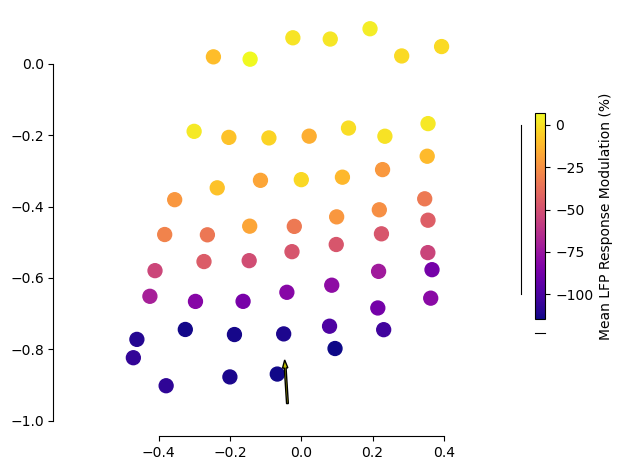

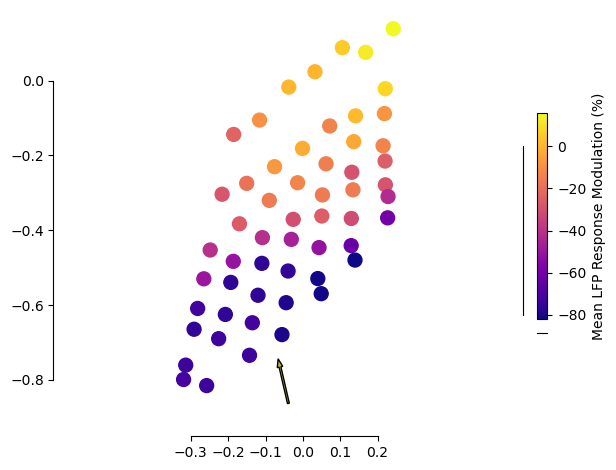

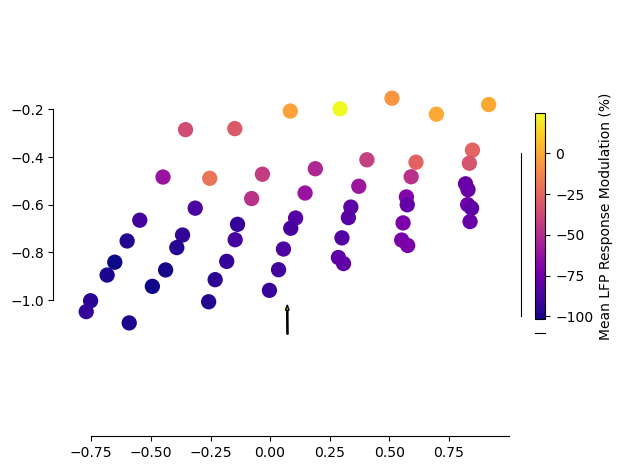

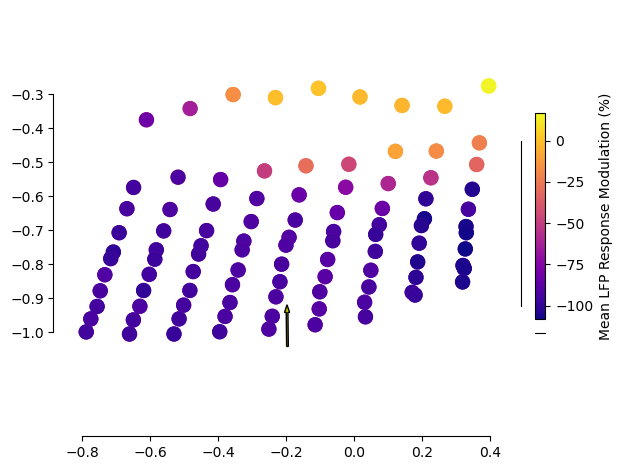

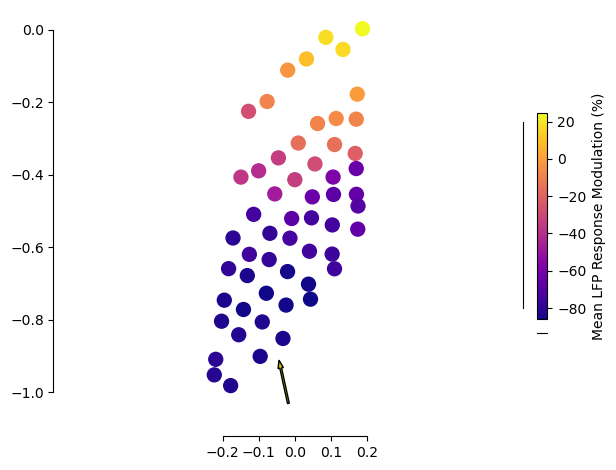

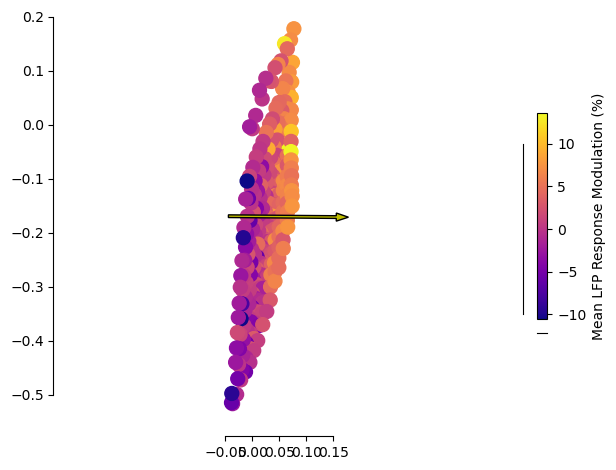

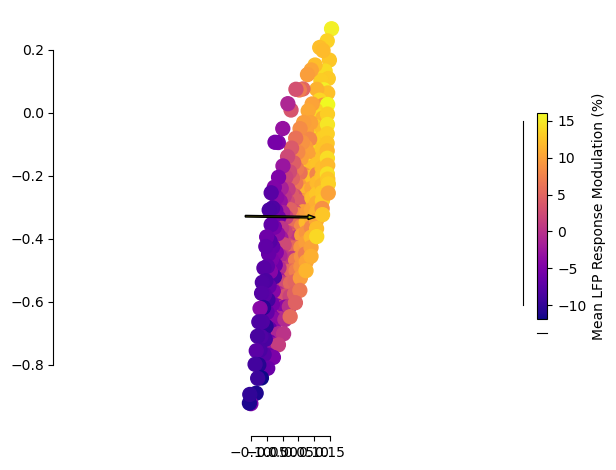

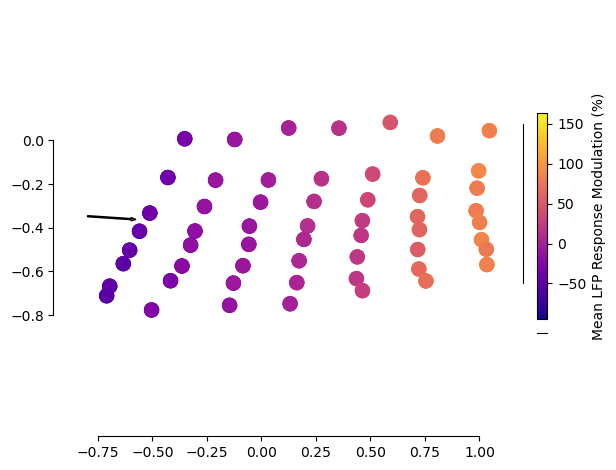

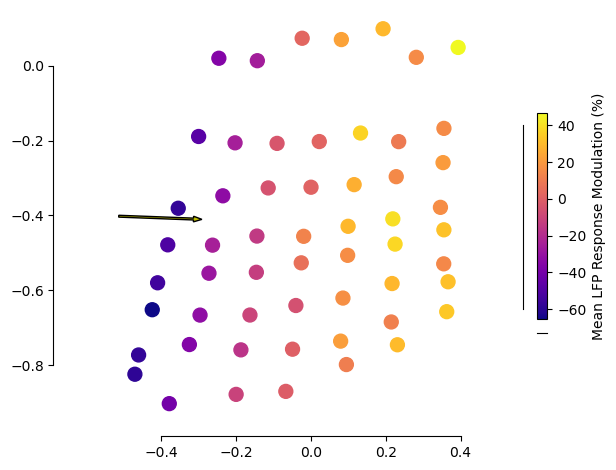

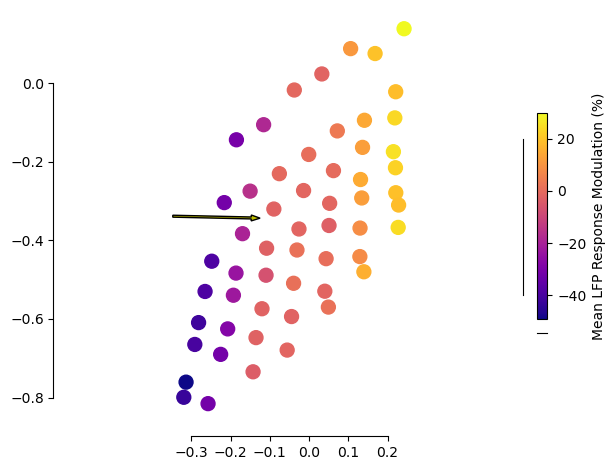

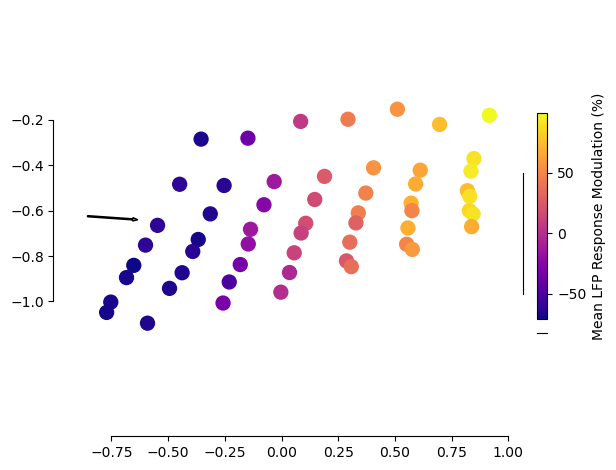

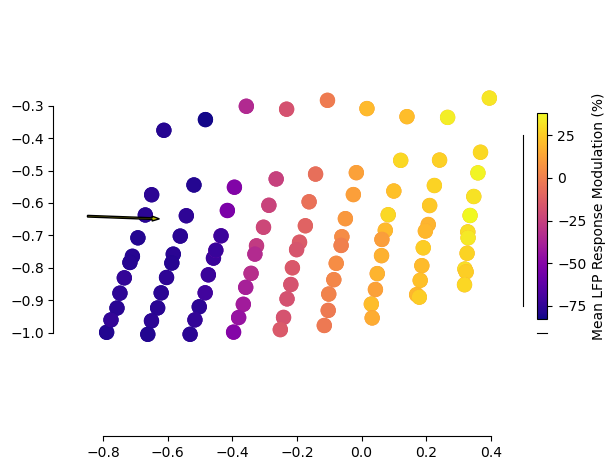

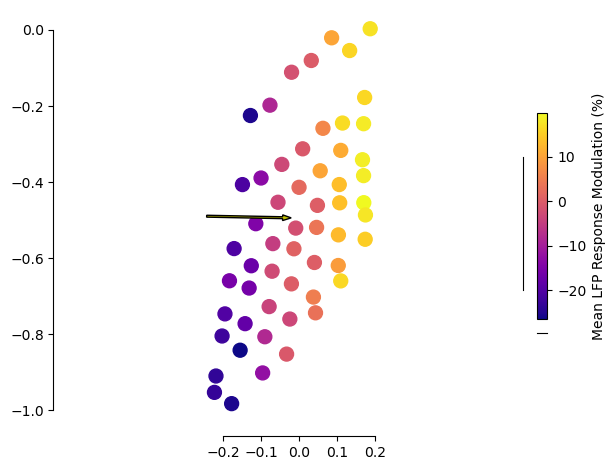

In [235]:
alignment_summary_convfeats = lfp_data.groupby(["zone", "fish_id"]).apply(plot_alignment_heatmap_conv_feats).dropna(axis=0).reset_index()

In [236]:
alignment_summary_convfeats

,zone,fish_id,grad_angle,grad_vec,reg_r2
0,dlz,fish_01,119.081271,"[-0.48604972807835417, 0.8739311539446102]",0.895847
1,dlz,fish_03,115.953167,"[-0.4376363359722501, 0.8991520658024336]",0.927581
2,dlz,fish_06,91.549118,"[-0.027033914771694815, 0.9996345169371237]",0.840301
3,dlz,fish_09,93.666409,"[-0.06394724405716637, 0.9979532804583053]",0.859613
4,dlz,fish_10,103.010077,"[-0.225122412148116, 0.9743304878472262]",0.864379
5,dlz,fish_11,90.463447,"[-0.008088580601700526, 0.9999672868968514]",0.797595
6,dlz,fish_12,90.669365,"[-0.01168236414881923, 0.9999317588555202]",0.516022
7,dlz,fish_13,102.313930,"[-0.21326792492394908, 0.976993752384647]",0.843551
8,mz,fish_01,-0.471394,"[0.9999661552652006, -0.008227291421408617]",0.657266
9,mz,fish_03,-0.860799,"[0.9998871452799286, -0.015023205515305425]",0.926377


In [237]:
alignment_summary_convfeats.groupby("zone").apply(lambda x: pd.Series(dict(angle_mean=x["grad_angle"].mean(), angle_std=x["grad_angle"].std(), reg_r2_avg=x["reg_r2"].mean())))

,angle_mean,angle_std,reg_r2_avg
zone,,,
dlz,100.838348,11.445080,0.818111
mz,-1.987846,1.326435,0.883572


## Alignment summary plot